
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 2 <br>
<font color=696880 size=4>
    Armin Ghojehzadeh

____

# 🔴 **Import Libs**

In [ ]:
!pip install portalocker
!pip install torchdata
!pip install torchtext==0.15.2
!pip install torchmetrics

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torchtext

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

In [ ]:
import torch
import torchtext
from torch.utils.data import DataLoader

from torchtext.data.utils import get_tokenizer
from collections import Counter
#from torchtext.vocab import Vocab



# Tokenize the text
tokenizer = get_tokenizer("basic_english")
tokens = [tokenizer(item) for item in train_iter]

# Build the vocabulary
counter = Counter([token for sublist in tokens for token in sublist])
vocab = Vocab(counter, specials=['<unk>', '<pad>', '<eos>'], min_freq=1)

# Function to convert tokens to IDs
def data_process(data):
    return torch.tensor([vocab[token] for line in data for token in line] + [vocab['<eos>']], dtype=torch.long)

train_data = data_process(tokens)

# Prepare DataLoader
batch_size = 32
seq_len = 30

def batchify(data, batch_size):
    num_batches = data.size(0) // batch_size
    data = data[:num_batches * batch_size]
    return data.view(batch_size, -1).contiguous()

train_data = batchify(train_data, batch_size)

def get_batch(data, i, seq_len):
    seq_start = i * seq_len
    seq_end = seq_start + seq_len
    input_seq = data[:, seq_start:seq_end]
    target_seq = data[:, seq_start + 1:seq_end + 1]
    return input_seq, target_seq

# Example: Accessing the first batch
input_seq, target_seq = get_batch(train_data, 0, seq_len)

AttributeError: 'NoneType' object has no attribute 'Lock'
This exception is thrown by __iter__ of _MemoryCellIterDataPipe(remember_elements=1000, source_datapipe=_ChildDataPipe)

In [ ]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        out, hidden = self.lstm(embedded, hidden)
        out = self.fc(out)
        return out, hidden

# Model parameters
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
num_layers = 2

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, num_layers)


NameError: name 'vocab' is not defined

In [ ]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
seq_len = 30
hidden_state = None

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for i in range(0, train_data.size(1) // seq_len):
        input_seq, target_seq = get_batch(train_data, i, seq_len)

        optimizer.zero_grad()

        # Forward pass
        output, hidden_state = model(input_seq, hidden_state)
        hidden_state = (hidden_state[0].detach(), hidden_state[1].detach())

        # Reshape output and target for loss calculation
        output = output.view(-1, vocab_size)
        target_seq = target_seq.view(-1)

        loss = criterion(output, target_seq)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / (train_data.size(1) // seq_len)}")


In [ ]:
import random

def generate_text(model, vocab, start_text, max_len=50, temperature=1.0):
    model.eval()
    input_seq = torch.tensor([vocab[token] for token in start_text.split()], dtype=torch.long).unsqueeze(0)
    hidden = None
    generated_text = start_text.split()

    for _ in range(max_len):
        with torch.no_grad():
            output, hidden = model(input_seq, hidden)

        # Apply temperature
        output = output[:, -1, :] / temperature
        probabilities = torch.softmax(output, dim=-1).squeeze().cpu().numpy()
        next_token_id = random.choices(range(len(vocab)), probabilities)[0]
        next_token = vocab.itos[next_token_id]

        if next_token == '<eos>':
            break

        generated_text.append(next_token)
        input_seq = torch.tensor([[next_token_id]], dtype=torch.long)

    return ' '.join(generated_text)

# Example: Generate text
start_text = "The quick brown fox"
generated = generate_text(model, vocab, start_text)
print(generated)


In [ ]:
!python --version
print(torch.__version__)
print(torchtext.__version__)

Python 3.10.12
2.0.1+cu117
0.15.2+cpu


In [ ]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 2.0.1+cu117
torchtext --> 0.15.2+cpu
tqdm --> 4.67.1


# 🔴 **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Load the Dataset**

🔰 In this session you should load WikiText2 dataset.

In [ ]:
import os
from functools import partial
from typing import Union, Tuple

from torchdata.datapipes.iter import FileOpener, IterableWrapper
from torchtext._download_hooks import HttpReader
from torchtext._internal.module_utils import is_module_available
from torchtext.data.datasets_utils import (
    _wrap_split_argument,
    _create_dataset_directory,
)

#URL = "https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip"

#MD5 = "542ccefacc6c27f945fb54453812b3cd"

URL = "http://la.ihainan.me/wikitext-2-v1.zip"
MD5 = "f6e734fc17885b364243f67b30385a3d"

NUM_LINES = {
    "train": 36718,
    "valid": 3760,
    "test": 4358,
}

DATASET_NAME = "WikiText2"

_EXTRACTED_FILES = {
    "train": os.path.join("wikitext-2", "wiki.train.tokens"),
    "test": os.path.join("wikitext-2", "wiki.test.tokens"),
    "valid": os.path.join("wikitext-2", "wiki.valid.tokens"),
}


def _filepath_fn(root, _=None):
    return os.path.join(root, os.path.basename(URL))


def _extracted_filepath_fn(root, split, _=None):
    return os.path.join(root, _EXTRACTED_FILES[split])


def _filter_fn(split, x):
    return _EXTRACTED_FILES[split] in x[0]


@_create_dataset_directory(dataset_name=DATASET_NAME)
@_wrap_split_argument(("train", "valid", "test"))
def WikiText2(root: str, split: Union[Tuple[str], str]):
    """WikiText2 Dataset

    .. warning::

        using datapipes is still currently subject to a few caveats. if you wish
        to use this dataset with shuffling, multi-processing, or distributed
        learning, please see :ref:`this note <datapipes_warnings>` for further
        instructions.

    For additional details refer to https://blog.salesforceairesearch.com/the-wikitext-long-term-dependency-language-modeling-dataset/

    Number of lines per split:
        - train: 36718
        - valid: 3760
        - test: 4358

    Args:
        root: Directory where the datasets are saved. Default: os.path.expanduser('~/.torchtext/cache')
        split: split or splits to be returned. Can be a string or tuple of strings. Default: (`train`, `valid`, `test`)

    :returns: DataPipe that yields text from Wikipedia articles
    :rtype: str
    """
    if not is_module_available("torchdata"):
        raise ModuleNotFoundError(
            "Package `torchdata` not found. Please install following instructions at https://github.com/pytorch/data"
        )

    url_dp = IterableWrapper([URL])
    # cache data on-disk
    cache_compressed_dp = url_dp.on_disk_cache(
        filepath_fn=partial(_filepath_fn, root),
        hash_dict={_filepath_fn(root): MD5},
        hash_type="md5",
    )
    cache_compressed_dp = HttpReader(cache_compressed_dp).end_caching(mode="wb", same_filepath_fn=True)
    cache_decompressed_dp = cache_compressed_dp.on_disk_cache(filepath_fn=partial(_extracted_filepath_fn, root, split))
    # Extract zip and filter the appropriate split file
    cache_decompressed_dp = (
        FileOpener(cache_decompressed_dp, mode="b").load_from_zip().filter(partial(_filter_fn, split))
    )
    cache_decompressed_dp = cache_decompressed_dp.end_caching(mode="wb", same_filepath_fn=True)
    data_dp = FileOpener(cache_decompressed_dp, encoding="utf-8")
    return data_dp.readlines(strip_newline=False, return_path=False).shuffle().set_shuffle(False).sharding_filter()


In [ ]:
# Load the dataset
train_data = WikiText2(split='train')
train_data = [_p for _p in train_data]

valid_data = WikiText2(split='valid')
valid_data = [_p for _p in valid_data]

test_data = WikiText2(split='test')
test_data = [_p for _p in test_data]



## 🟠 **Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [ ]:
from collections import Counter
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Defining a tokenizer
tokenizer = get_tokenizer("basic_english")
tokenized_dataset =  [tokenizer(item) for item in train_data]

# Count the occurrences of each word
word_counts = Counter(token for tokens in tokenized_dataset for token in tokens)

# Filter out non-repetitive words
filtered_tokens = [[token for token in tokens if word_counts[token] > 1] for tokens in tokenized_dataset]

# Build the vocabulary
def yield_tokens(data):
    for tokens in data:
        yield tokens

vocab = build_vocab_from_iterator(yield_tokens(filtered_tokens), specials=["<unk>", "<pad>", "<eos>"])
vocab.set_default_index(vocab["<unk>"])

# Manually insert special tokens
vocab.insert_token("<bos>", 0)
vocab.set_default_index(vocab["<unk>"])

# Test the vocabulary
sample_tokens = ["the", "quick", "brown", "<eos>", "unknown_token"]
indices = vocab(sample_tokens)
print("Indices:", indices)

reconstructed_tokens = [vocab.lookup_token(idx) for idx in indices]
print("Reconstructed Tokens:", reconstructed_tokens)

Indices: [4, 3278, 566, 3, 1]
Reconstructed Tokens: ['the', 'quick', 'brown', '<eos>', '<unk>']


## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [ ]:
num_data = len(train_data)
total_words = sum(len(train_data) for item in train_data)
avg_length = total_words / num_data

# Maximum and Minimum Document Length
lengths = [len(item) for item in tokenized_dataset]
max_length = max(lengths)
min_length = min(lengths)

# Vocabulary Size
all_words = [word.lower() for doc in tokenized_dataset for word in doc]
vocabulary = set(all_words)
vocab_size = len(vocabulary)

# Word Frequency Distribution
word_freq = Counter(all_words)

# Average Word Length
avg_word_length = np.mean([len(word) for word in all_words])

# Display Results
print(f"Number of Documents: {num_data}")
print(f"Total Words: {total_words}")
print(f"Average Document Length: {avg_length:.2f} words")
print(f"Maximum Document Length: {max_length} words")
print(f"Minimum Document Length: {min_length} words")
print(f"Vocabulary Size: {vocab_size}")
print(f"Top 5 Frequent Words: {word_freq.most_common(5)}")
print(f"Average Word Length: {avg_word_length:.2f} characters")

Number of Documents: 36718
Total Words: 1348211524
Average Document Length: 36718.00 words
Maximum Document Length: 696 words
Minimum Document Length: 0 words
Vocabulary Size: 28782
Top 5 Frequent Words: [('the', 130768), (',', 102615), ('.', 83397), ('of', 57030), ('<unk>', 54625)]
Average Word Length: 4.20 characters


### 🟡 Analyze the most common and least common words in the dataset.

### 🟡  Please proceed with further exploration of the dataset. what do you suggest?
A word cloud is an excellent way to visualize word frequencies:

Larger words indicate higher frequencies.
It provides an intuitive understanding of common terms.

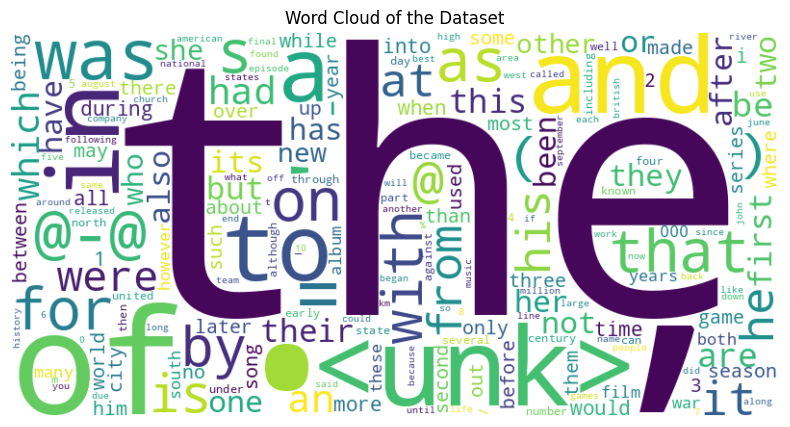

Most Common Bigrams: [(('of', 'the'), 17322), (('=', '='), 17120), (("'", 's'), 14026), (('in', 'the'), 11823), ((',', 'and'), 11713)]
Most Common Trigrams: [(('=', '=', '='), 5956), (('@', '.', '@'), 3194), (('@', ',', '@'), 2699), ((',', '@', '000'), 1446), ((',', 'and', 'the'), 1407)]


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

# Display Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of the Dataset")
plt.show()


from collections import Counter
from nltk.util import ngrams

# Generate bigrams
bigrams = [bigram for doc in tokenized_dataset for bigram in ngrams(doc, 2)]
bigram_freq = Counter(bigrams)

# Top 5 bigrams
print("Most Common Bigrams:", bigram_freq.most_common(5))

# Generate trigrams
trigrams = [trigram for doc in tokenized_dataset for trigram in ngrams(doc, 3)]
trigram_freq = Counter(trigrams)

# Top 5 trigrams
print("Most Common Trigrams:", trigram_freq.most_common(5))

## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [ ]:
def data_process(raw_text_iter, seq_len, vocab):
    raw_text_iter = torch.tensor([vocab[token] for line in raw_text_iter for token in line], dtype=torch.long)

    inputs = []
    targets = []

    for i in range(seq_len, len(raw_text_iter)-1):
      inputs.append(raw_text_iter[i-seq_len: i])
      targets.append(raw_text_iter[i])

    return inputs, targets


train_inputs, train_targets = data_process([tokenizer(item) for item in train_data], 30, vocab)
val_inputs, val_targets  = data_process([tokenizer(item) for item in valid_data], 30, vocab)

## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [ ]:
class LanguageModelDataset(Dataset):
  def __init__(self, inputs, targets):
      self.data = list(zip(inputs, targets))
      self.len = len(targets)

  def __len__(self):
      return self.len

  def __getitem__(self, idx):
      return self.data[idx]


train_ds = LanguageModelDataset(train_inputs, train_targets)
val_ds = LanguageModelDataset(val_inputs, val_targets)

## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [ ]:
batch_size = 30

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = []
        for i in range(num_layers-1):
            self.fc.append(nn.Sequential(
              nn.Linear(hidden_dim, hidden_dim),
              nn.ReLU(),
              nn.Dropout(dropout_rate)
          ))

        self.last_layer = nn.Linear(hidden_dim, vocab_size)


    def forward(self, src):
        embedded = self.embedding(src)
        #print(embedded.shape)
        output, _ = self.rnn(embedded)
        last_hidden = output[:, -1, :]

        for i in range(len(self.fc)-1):
          last_hidden = self.fc[i](last_hidden)

        logits = self.last_layer(last_hidden)
        return logits


# 🔴 **Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [ ]:
# Training parameters
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 128
num_epochs = 10
learning_rate = 0.001
num_layers = 0


# Define the loss function and optimizer
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, learning_rate)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs, targets)

print(loss)

tensor(10.3120)


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, 3, 0.2)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [ ]:
import torchmetrics

num_epochs = 50
metric = torchmetrics.Accuracy(task="multiclass", num_classes=vocab_size)

train_subset = DataLoader(train_ds[300:600], batch_size=batch_size, shuffle=True)
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, train_subset, loss_fn, optimizer, metric, epoch)

Epoch 49: 100%|██████████| 10/10 [00:01<00:00,  5.60batch/s, loss=10.2, metric=0.06]


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs = 10

for lr in [1e-2, 1e-1, 1, 10]:
  print(f'LR={lr}')

  model = LanguageModel(vocab_size, embedding_dim, hidden_dim, 3, 0.2)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, DataLoader(train_ds[300:600], batch_size=batch_size, shuffle=True), loss_fn, optimizer, metric, epoch)

  print()

LR=0.01


Epoch 9: 100%|██████████| 10/10 [00:01<00:00,  9.61batch/s, loss=10.1, metric=0.06]



LR=0.1


Epoch 9: 100%|██████████| 10/10 [00:02<00:00,  3.70batch/s, loss=5.22, metric=0.07]



LR=1


Epoch 9: 100%|██████████| 10/10 [00:01<00:00,  6.01batch/s, loss=0.454, metric=0.867]



LR=10


Epoch 9: 100%|██████████| 10/10 [00:02<00:00,  4.49batch/s, loss=9.26, metric=0.0733]

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs =

for lr in [...]:
  for wd in [...]:
    print(f'LR={lr}, WD={wd}')

    model =
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

    print()

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, 3, 0.2)

In [ ]:
lr = 1
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 2

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

 70%|███████   | 47975/68332 [1:39:09<35:13,  9.63batch/s, loss=6.64, metric=0.137]

## 🟠 Main Loop

🔰 Define model.

In [ ]:
model =

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:
lr =
wd =
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs =

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_set,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_set,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

## 🟠 Plot

🔰 Plot learning curves

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set

# 🔴 **Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

In [ ]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
    pass